# GD4 Proj 프로젝트: 개선된 U-Net 모델 만들기

[참고자료, U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)

In [73]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import matplotlib.pyplot as plt

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

## KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

# augmentation 기능을 뱉어내는 함수
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

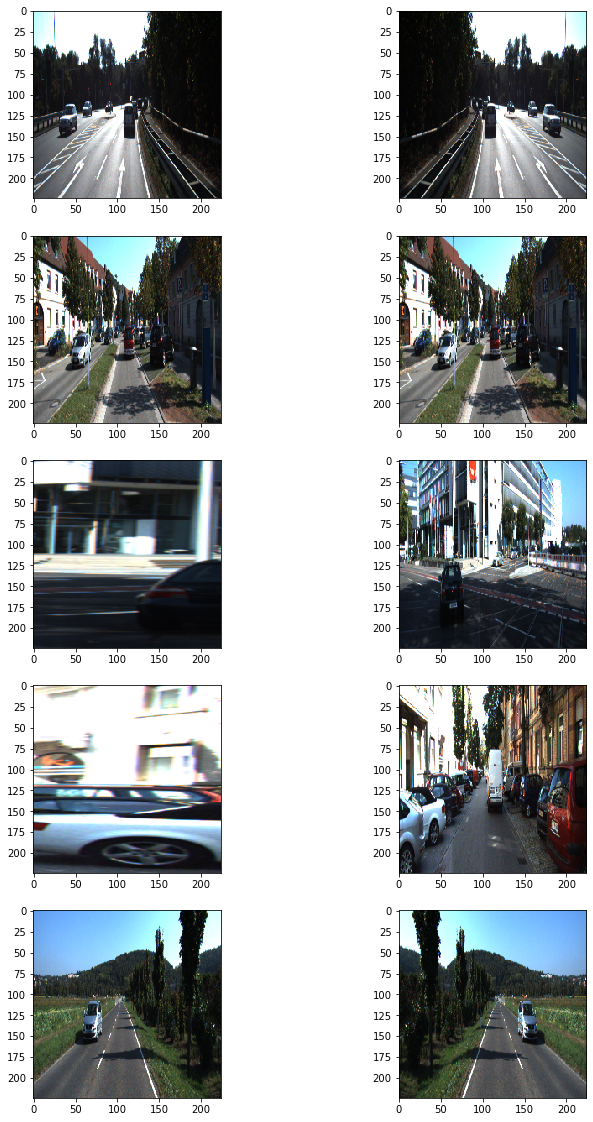

In [9]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [10]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
            #    batch_size=16,
            batch_size = 4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
		# AssertionError 발생여부를 통해 상황 점검
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [11]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net이 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

[참고자료,  Semantic Segmentation With U-Net++](https://www.kaggle.com/ekhtiar/tf-tutorial-semantic-segmentation-with-u-net)

In [25]:
dropout_rate = 0.5

In [26]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [27]:
def build_model(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    model = None

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    bn_axis = 3
    img_input = Input(input_shape, name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])

    return model

In [28]:
import pickle
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

save_history_path = './history' 


In [29]:
model = build_model()

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 224, 224, 32) 896         main_input[0][0]                 
__________________________________________________________________________________________________
dp11_1 (Dropout)                (None, 224, 224, 32) 0           conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 224, 224, 32) 9248        dp11_1[0][0]                     
_______________________________________________________________________________________

In [30]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
hist = model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     verbose = 1
 )

model_path = dir_path + '/seg_model_unet_plus.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 7s 162ms/step - loss: 2.1336 - val_loss: 1.0429
Epoch 2/100
43/43 [==============================] - 7s 152ms/step - loss: 1.0741 - val_loss: 1.1765
Epoch 3/100
43/43 [==============================] - 7s 171ms/step - loss: 0.9594 - val_loss: 1.1372
Epoch 4/100
43/43 [==============================] - 7s 171ms/step - loss: 0.9284 - val_loss: 1.5098
Epoch 5/100
43/43 [==============================] - 7s 159ms/step - loss: 0.8918 - val_loss: 1.3794
Epoch 6/100
43/43 [==============================] - 7s 156ms/step - loss: 0.8571 - val_loss: 1.9938
Epoch 7/100
43/43 [==============================] - 7s 162ms/step - loss: 0.8365 - val_loss: 2.6636
Epoch 8/100
43/43 [==============================] - 7s 160ms/step - loss: 0.8249 - val_loss: 1.7255
Epoch 9/100
43/43 [==============================] - 8s 185ms/step - loss: 0.7974 - val_loss: 1.4305
Epoch 10/100
43

FileNotFoundError: [Errno 2] No such file or directory: './history/seg_model_unet_plus'

In [47]:
with open(save_history_path+'/'+'seg_model_unet_plus', 'wb') as file:
            model_history= History_trained_model(hist.history, hist.epoch, hist.params)
            pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

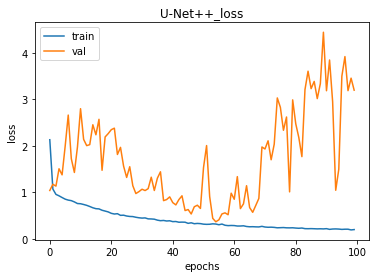

In [58]:
for i, met in enumerate(['loss']):
    plt.plot(hist.history[met])
    plt.plot(hist.history['val_' + met])
    plt.title('U-Net++_'+met)
    plt.xlabel('epochs')
    plt.ylabel(met)
    plt.legend(['train', 'val'])

흠...과적합이 발생하는것같다! 55에서 학습을 멈추자. 

In [59]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
hist = model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=55,
     verbose = 1
 )

model_path = dir_path + '/seg_model_unet_plus.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

with open(save_history_path+'/'+'seg_model_unet_plus', 'wb') as file:
            model_history= History_trained_model(hist.history, hist.epoch, hist.params)
            pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

Epoch 1/55
43/43 [==============================] - 9s 209ms/step - loss: 0.1972 - val_loss: 4.0019
Epoch 2/55
43/43 [==============================] - 8s 197ms/step - loss: 0.1998 - val_loss: 4.1415
Epoch 3/55
43/43 [==============================] - 8s 195ms/step - loss: 0.1938 - val_loss: 3.4737
Epoch 4/55
43/43 [==============================] - 9s 198ms/step - loss: 0.1857 - val_loss: 3.8172
Epoch 5/55
43/43 [==============================] - 9s 202ms/step - loss: 0.1907 - val_loss: 3.3385
Epoch 6/55
43/43 [==============================] - 8s 197ms/step - loss: 0.1827 - val_loss: 1.2457
Epoch 7/55
43/43 [==============================] - 9s 199ms/step - loss: 0.1806 - val_loss: 0.5122
Epoch 8/55
43/43 [==============================] - 9s 200ms/step - loss: 0.1865 - val_loss: 0.5306
Epoch 9/55
43/43 [==============================] - 9s 202ms/step - loss: 0.1824 - val_loss: 0.7413
Epoch 10/55
43/43 [==============================] - 9s 198ms/step - loss: 0.1832 - val_loss: 1.5656

### 55 epoch 까지만 돌린 결과 시각화

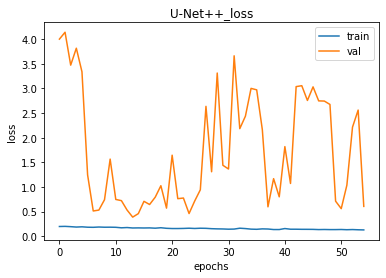

In [60]:
for i, met in enumerate(['loss']):
    plt.plot(hist.history[met])
    plt.plot(hist.history['val_' + met])
    plt.title('U-Net++_'+met)
    plt.xlabel('epochs')
    plt.ylabel(met)
    plt.legend(['train', 'val'])

## U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [61]:
def calculate_iou_score(target, prediction,is_plus=False,index = 1):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if is_plus:
        print('U-Net++ on img index_{0} / IoU : {1}'.format(index,iou_score))
    else:
        print('U-Net on img index_{0} / IoU : {1}'.format(index,iou_score))
    return iou_score

In [148]:
def get_output(model, preproc, image_path, output_path, label_path, threshold = 0.5, is_deep=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    # print(type(output),output)
    
    # 네 개의 결과가 나오기 때문에, 결과의 평균을 내주기 위해 이렇게 하기는 했는데... 맞는지는 확실치 않다!
    if is_deep:
        avg_output = output[0].numpy()
        for i in range(1,4):
            avg_output += output[i].numpy()
        output = avg_output/4

        output = (output[0]>=threshold).astype(np.uint8).squeeze(-1)*255

    else:
        output = (output[0].numpy()>=threshold).astype(np.uint8).squeeze(-1)*255 

    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.save(output_path)
    # output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### U-Net++(epoch 55, DeepSupervision X) 를 활용한 결과, U-Net 결과 비교

In [94]:
threshold = 0.5
model_path = dir_path + '/seg_model_unet_plus.h5'
model = tf.keras.models.load_model(model_path)
model_path_original = dir_path + '/seg_model_unet.h5'
model_original = tf.keras.models.load_model(model_path_original)

In [117]:
results = []
rands = np.random.randint(1,201,10)
for i in rands:
    
    output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_plus/result_plus_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold
 )

    s1 = calculate_iou_score(target, prediction,is_plus = True, index = i)    

    output_original, prediction_original, target_original = get_output(
     model_original, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result/result_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold
 )

    s2 = calculate_iou_score(target_original, prediction_original, is_plus = False, index = i)

    results.append({'index':i,'U-Net++_IoU':s1,'U-Net_IoU':s2})

U-Net++ on img index_193 / IoU : 0.0004013163175214704
U-Net on img index_193 / IoU : 0.618854152320617
U-Net++ on img index_120 / IoU : 0.08187257268814947
U-Net on img index_120 / IoU : 0.6654333008763389
U-Net++ on img index_4 / IoU : 0.000279876854184159
U-Net on img index_4 / IoU : 0.5452151009657594
U-Net++ on img index_96 / IoU : 0.013383877456289649
U-Net on img index_96 / IoU : 0.9112493859505485
U-Net++ on img index_19 / IoU : 0.1942492603550296
U-Net on img index_19 / IoU : 0.633586221037523
U-Net++ on img index_55 / IoU : 0.06101859730156801
U-Net on img index_55 / IoU : 0.7570648878107944
U-Net++ on img index_188 / IoU : 0.0580757876980541
U-Net on img index_188 / IoU : 0.8664289472145905
U-Net++ on img index_152 / IoU : 0.01600392734413353
U-Net on img index_152 / IoU : 0.6705814717477004
U-Net++ on img index_9 / IoU : 0.15883771677960262
U-Net on img index_9 / IoU : 0.6596819457436857
U-Net++ on img index_193 / IoU : 0.0004013163175214704
U-Net on img index_193 / IoU : 0

In [118]:
results

[{'index': 193,
  'U-Net++_IoU': 0.0004013163175214704,
  'U-Net_IoU': 0.618854152320617},
 {'index': 120,
  'U-Net++_IoU': 0.08187257268814947,
  'U-Net_IoU': 0.6654333008763389},
 {'index': 4,
  'U-Net++_IoU': 0.000279876854184159,
  'U-Net_IoU': 0.5452151009657594},
 {'index': 96,
  'U-Net++_IoU': 0.013383877456289649,
  'U-Net_IoU': 0.9112493859505485},
 {'index': 19,
  'U-Net++_IoU': 0.1942492603550296,
  'U-Net_IoU': 0.633586221037523},
 {'index': 55,
  'U-Net++_IoU': 0.06101859730156801,
  'U-Net_IoU': 0.7570648878107944},
 {'index': 188,
  'U-Net++_IoU': 0.0580757876980541,
  'U-Net_IoU': 0.8664289472145905},
 {'index': 152,
  'U-Net++_IoU': 0.01600392734413353,
  'U-Net_IoU': 0.6705814717477004},
 {'index': 9,
  'U-Net++_IoU': 0.15883771677960262,
  'U-Net_IoU': 0.6596819457436857},
 {'index': 193,
  'U-Net++_IoU': 0.0004013163175214704,
  'U-Net_IoU': 0.618854152320617}]

### U-Net++ 의 성능이 훨씬 떨어지는 상황! deep supervision 을 적용한 모델로 다시 만들고, 학습시켜서 진행해보겠다.

In [70]:
model_plus_deep = build_model(deep_supervision=True)

model_plus_deep.summary()

________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 224, 224, 32) 896         main_input[0][0]                 
__________________________________________________________________________________________________
dp11_1 (Dropout)                (None, 224, 224, 32) 0           conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 224, 224, 32) 9248        dp11_1[0][0]                     
__________________________________________________________________________________________________
dp11_2 (Dropout)                (None, 224, 224, 32) 0           conv11_2[0][0]     

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [79]:
model_plus_deep.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
hist_plus_deep = model_plus_deep.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     verbose = 1,
     callbacks = [es]
 )

model_plus_deep_path = dir_path + '/seg_model_unet_plus_deep.h5'
model_plus_deep.save(model_plus_deep_path)  #학습한 모델을 저장해 주세요.

734 - output_4_loss: 0.0649 - val_loss: 1.9716 - val_output_1_loss: 0.6703 - val_output_2_loss: 0.4274 - val_output_3_loss: 0.2401 - val_output_4_loss: 0.3494
Epoch 37/100
43/43 [==============================] - 9s 211ms/step - loss: 0.6208 - output_1_loss: 0.1043 - output_2_loss: 0.0899 - output_3_loss: 0.0786 - output_4_loss: 0.0650 - val_loss: 2.2393 - val_output_1_loss: 0.6532 - val_output_2_loss: 0.3996 - val_output_3_loss: 0.2955 - val_output_4_loss: 0.6093
Epoch 38/100
43/43 [==============================] - 9s 210ms/step - loss: 0.5756 - output_1_loss: 0.0925 - output_2_loss: 0.0776 - output_3_loss: 0.0671 - output_4_loss: 0.0580 - val_loss: 2.3897 - val_output_1_loss: 0.6513 - val_output_2_loss: 0.3721 - val_output_3_loss: 0.4757 - val_output_4_loss: 0.6116
Epoch 39/100
43/43 [==============================] - 9s 208ms/step - loss: 0.5749 - output_1_loss: 0.0914 - output_2_loss: 0.0772 - output_3_loss: 0.0667 - output_4_loss: 0.0618 - val_loss: 2.4477 - val_output_1_loss: 0.

### 다시 결과 비교 (U-Net original 과 U-Net++ DeepSupervision 적용한 버전)

In [99]:
threshold = 0.5
model_plus_deep_path = dir_path + '/seg_model_unet_plus_deep.h5'
model_plus_deep = tf.keras.models.load_model(model_plus_deep_path)
model_path_original = dir_path + '/seg_model_unet.h5'
model_original = tf.keras.models.load_model(model_path_original)

In [131]:
rands = np.random.randint(1,201,10)
for i in rands:
    
    output, prediction, target = get_output(
     model_plus_deep, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_plus/result_plus_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold,
  is_deep = True
 )

    s1 = calculate_iou_score(target, prediction,is_plus = True, index = i)    

    output_original, prediction_original, target_original = get_output(
     model_original, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result/result_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold
 )

    s2 = calculate_iou_score(target_original, prediction_original, is_plus = False, index = i)

    results.append({'index':i,'U-Net++_IoU':s1,'U-Net_IoU':s2})

U-Net++ on img index_61 / IoU : 0.3643676286754715
U-Net on img index_61 / IoU : 0.7718691454100014
U-Net++ on img index_125 / IoU : 0.205932317648645
U-Net on img index_125 / IoU : 0.6984378298501162
U-Net++ on img index_46 / IoU : 0.4721512260546094
U-Net on img index_46 / IoU : 0.7815179711731436
U-Net++ on img index_108 / IoU : 0.5590911128041949
U-Net on img index_108 / IoU : 0.6225965358334657
U-Net++ on img index_68 / IoU : 0.37902271014960714
U-Net on img index_68 / IoU : 0.7498282731144388
U-Net++ on img index_24 / IoU : 0.37932692307692306
U-Net on img index_24 / IoU : 0.6902440812138093
U-Net++ on img index_118 / IoU : 0.19344576991635815
U-Net on img index_118 / IoU : 0.6135633169059352
U-Net++ on img index_55 / IoU : 0.3142725867758239
U-Net on img index_55 / IoU : 0.7570648878107944
U-Net++ on img index_64 / IoU : 0.47782837967401726
U-Net on img index_64 / IoU : 0.6713501646542261
U-Net++ on img index_137 / IoU : 0.3507675552328597
U-Net on img index_137 / IoU : 0.819465

In [132]:
results

[{'index': 193,
  'U-Net++_IoU': 0.0004013163175214704,
  'U-Net_IoU': 0.618854152320617},
 {'index': 120,
  'U-Net++_IoU': 0.08187257268814947,
  'U-Net_IoU': 0.6654333008763389},
 {'index': 4,
  'U-Net++_IoU': 0.000279876854184159,
  'U-Net_IoU': 0.5452151009657594},
 {'index': 96,
  'U-Net++_IoU': 0.013383877456289649,
  'U-Net_IoU': 0.9112493859505485},
 {'index': 19,
  'U-Net++_IoU': 0.1942492603550296,
  'U-Net_IoU': 0.633586221037523},
 {'index': 55,
  'U-Net++_IoU': 0.06101859730156801,
  'U-Net_IoU': 0.7570648878107944},
 {'index': 188,
  'U-Net++_IoU': 0.0580757876980541,
  'U-Net_IoU': 0.8664289472145905},
 {'index': 152,
  'U-Net++_IoU': 0.01600392734413353,
  'U-Net_IoU': 0.6705814717477004},
 {'index': 9,
  'U-Net++_IoU': 0.15883771677960262,
  'U-Net_IoU': 0.6596819457436857},
 {'index': 193,
  'U-Net++_IoU': 0.0004013163175214704,
  'U-Net_IoU': 0.618854152320617},
 {'index': 61,
  'U-Net++_IoU': 0.3643676286754715,
  'U-Net_IoU': 0.7718691454100014},
 {'index': 125,
  

### 여전히 U-Net++ 가 더 낮은 성능을 보여줌을 알 수 있다! 시각화를 해서 살펴보니, 도로가 아닌 부분들까지 다 도로로 인식하는 문제가 있는 것 같다!   
그래서, U-Net++ 에서는 threshold를 조금 높혀서 확인해보고자 한다.

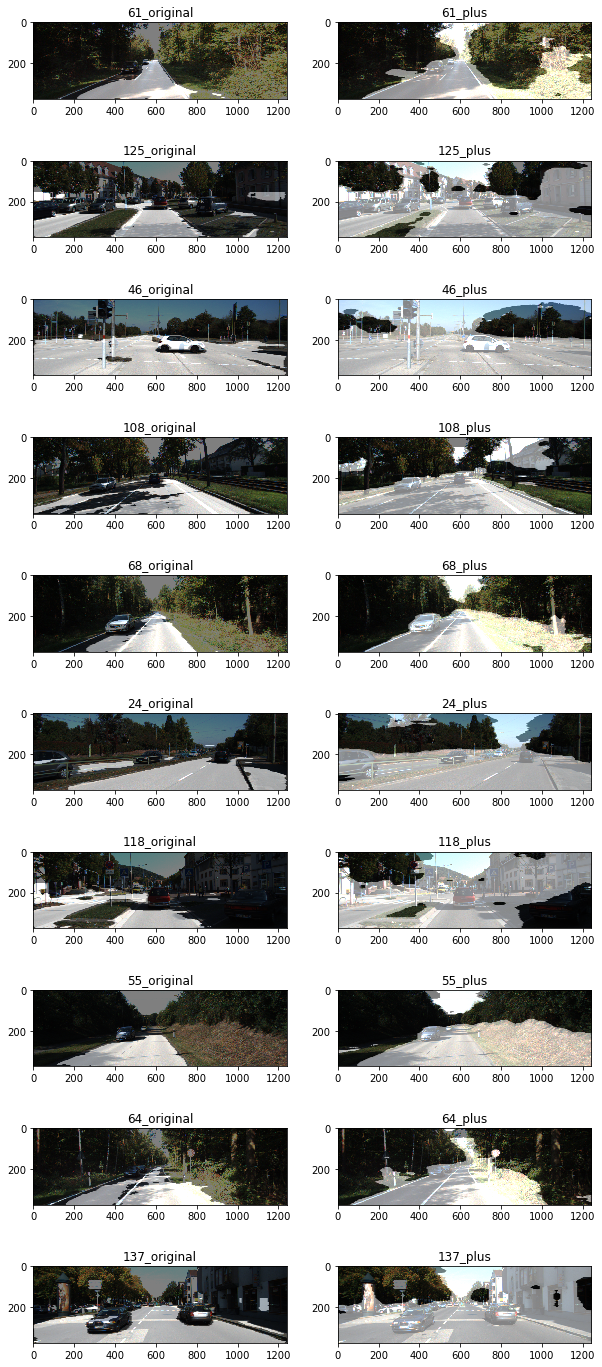

In [141]:
fig, ax = plt.subplots(10, 2, figsize=(10, 25))

for idx,i in enumerate(rands):

    output_path_original=glob(dir_path + f'/result/result_{str(i).zfill(3)}_{int(threshold*100)}.png')[0]
    output_path_plus=glob(dir_path + f'/result_plus/result_plus_{str(i).zfill(3)}_{int(threshold*100)}.png')[0]

    img_original = imread(output_path_original)
    img_plus = imread(output_path_plus)

    ax[idx][0].imshow(img_original)
    ax[idx][0].set_title('{}_original'.format(i))

    ax[idx][1].imshow(img_plus)
    ax[idx][1].set_title('{}_plus'.format(i))



### U-Net++ 에서 threshold 높혀보기

In [161]:
threshold_plus = 0.96
for i in rands:
    
    output, prediction, target = get_output(
     model_plus_deep, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_plus/result_plus_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold_plus,
  is_deep = True
 )

    s1 = calculate_iou_score(target, prediction,is_plus = True, index = i)    

    output_original, prediction_original, target_original = get_output(
     model_original, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result/result_{str(i).zfill(3)}_{int(threshold*100)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
  threshold = threshold
 )

    s2 = calculate_iou_score(target_original, prediction_original, is_plus = False, index = i)

    results.append({'index':i,'U-Net++_IoU':s1,'U-Net_IoU':s2})

U-Net++ on img index_61 / IoU : 0.6967469715530148
U-Net on img index_61 / IoU : 0.7718691454100014
U-Net++ on img index_125 / IoU : 0.47399658728392313
U-Net on img index_125 / IoU : 0.6984378298501162
U-Net++ on img index_46 / IoU : 0.7571033013844516
U-Net on img index_46 / IoU : 0.7815179711731436
U-Net++ on img index_108 / IoU : 0.8112786582551161
U-Net on img index_108 / IoU : 0.6225965358334657
U-Net++ on img index_68 / IoU : 0.6431308791081175
U-Net on img index_68 / IoU : 0.7498282731144388
U-Net++ on img index_24 / IoU : 0.6138713298280853
U-Net on img index_24 / IoU : 0.6902440812138093
U-Net++ on img index_118 / IoU : 0.3874757908327954
U-Net on img index_118 / IoU : 0.6135633169059352
U-Net++ on img index_55 / IoU : 0.3407279029462738
U-Net on img index_55 / IoU : 0.7570648878107944
U-Net++ on img index_64 / IoU : 0.5760939957442872
U-Net on img index_64 / IoU : 0.6713501646542261
U-Net++ on img index_137 / IoU : 0.6287410460209989
U-Net on img index_137 / IoU : 0.81946562

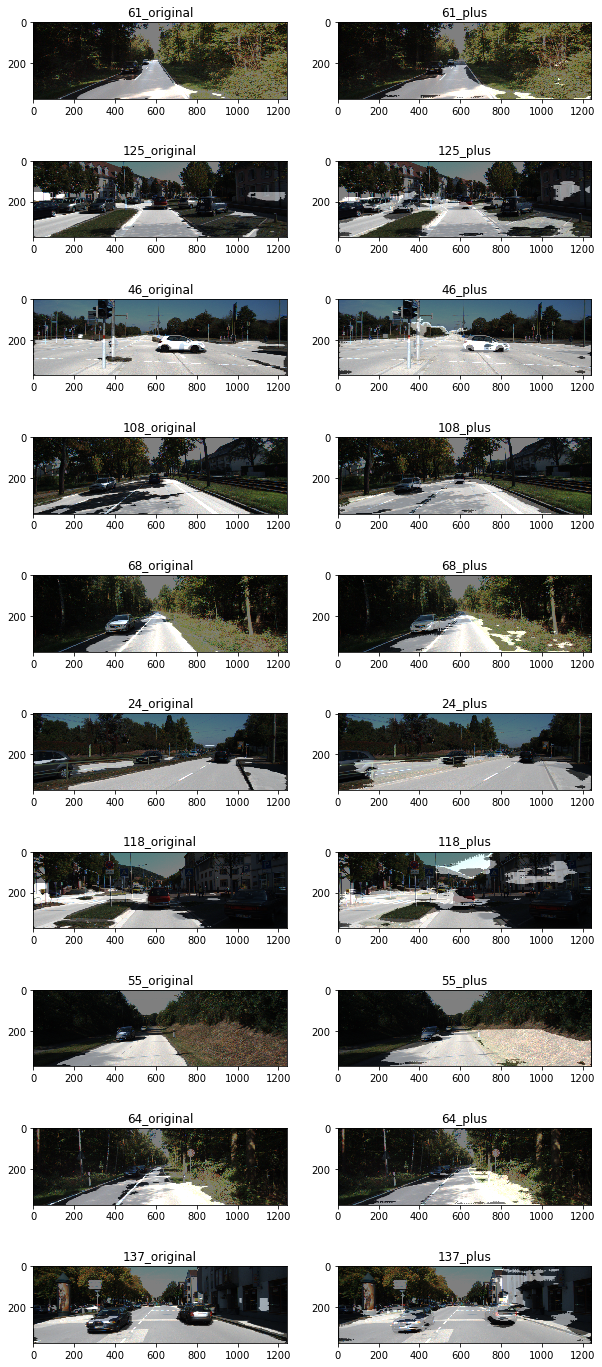

In [162]:
fig, ax = plt.subplots(10, 2, figsize=(10, 25))

for idx,i in enumerate(rands):

    output_path_original=glob(dir_path + f'/result/result_{str(i).zfill(3)}_{int(threshold*100)}.png')[0]
    output_path_plus=glob(dir_path + f'/result_plus/result_plus_{str(i).zfill(3)}_{int(threshold*100)}.png')[0]

    img_original = imread(output_path_original)
    img_plus = imread(output_path_plus)

    ax[idx][0].imshow(img_original)
    ax[idx][0].set_title('{}_original'.format(i))

    ax[idx][1].imshow(img_plus)
    ax[idx][1].set_title('{}_plus'.format(i))



## 결과 보고서

- 분명 U-Net++ 가 U-Net 보다 더 좋은 성능을 보여줘야 할텐데... 오히려 U-Net 보다 정성적, 정량적으로 모두 더 열등한 결과를 보여주었다.
- 모델 설계에 문제가 있었거나, 네 개의 output 값을 그냥 평균을 내서 사용하는 방식이 잘못되었을 것이라는 생각이 든다.